# LSTM - Glove

- ASAD Dataset
- ROS Balanced
- LSTM 1, 2 and 3 Layers
- Cell: 64
- Learning-rate: 0.001
- Embedding: Glove dim 300

## Import libraries

In [35]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import csv
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from keras import layers
from tensorflow.keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.callbacks import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import spatial
from gensim.utils import simple_preprocess
from keras.preprocessing import sequence
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import tensorflow as tf
from imblearn.over_sampling import SMOTE, RandomOverSampler

## Load dataset

In [36]:
file='../complete_training_all_punctuation_cleaning_stopword.csv'
data = pd.read_csv(file,header=0, delimiter="\t",encoding='utf-8')
data.text=data.text.astype(str)
data.head(100)

,id,text,sentiment
0,1221875106206638080,والله الأرقام سيكون مخيب للآمال الأهلي قدها بر...,Positive
1,1221884257490042887,الزعل بيغير ملامحك بيغير نظرة العين بيغير شكلك...,Neutral
2,1226422627436310528,الحب الحقيقي اقتسام شخص أخر أقرب احلام مستغانمي,Positive
3,1221880820815798277,النهضة فتيل,Positive
4,1221884400377499651,حباً ايران بقدر ماهو نكايه بترامب وحزبه,Neutral
...,...,...,...
95,1221882259139067911,ليه اسوم حياتي غيرت وانا اعرف,Neutral
96,1221881289881550848,هههه ضحكت حالة نفسية سعيده,Positive
97,1227326811652026368,الحمدلله حضنت امي الحقيقية تعرفون شنو شعور تتر...,Positive
98,1221882556548816896,توني ادري ان قناة اسمها يمدح السوق الا اللي رب...,Neutral


In [37]:
data.shape

(53289, 3)

In [38]:
labels = data[['id', 'sentiment']]
labels.sentiment.value_counts()

Neutral     36082
Negative     8674
Positive     8533
Name: sentiment, dtype: int64

In [39]:
classes = sorted(labels.sentiment.unique())
classes

['Negative', 'Neutral', 'Positive']

In [40]:
dfs = []
for sentiment in classes:
    df_temp = data.where(data.sentiment == sentiment)
    df_temp.dropna(axis=0, inplace=True)
    dfs.append(df_temp)
ls = [len(df) for df in dfs]
ls

[8674, 36082, 8533]

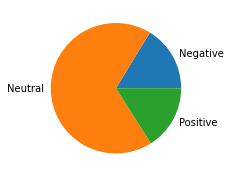

In [41]:
plt.figure(figsize=(3, 3))
plt.pie(ls, labels=classes);

## Augmented data

In [42]:
# new_dfs = [pd.concat([df]*int(max(ls)/len(df)), ignore_index=True) 
#           for df in dfs]

In [43]:
# new_ls = [len(df) for df in new_dfs]
# new_ls

In [44]:
# plt.figure(figsize=(3, 3))
# plt.pie(new_ls, labels=classes);

In [45]:
# data = pd.concat(new_dfs, ignore_index=True)
# labels = data[['id','text', 'sentiment']]
# classes = sorted(labels.sentiment.unique())
# classes

In [46]:
data["sentiment"].value_counts()
cleanup_nums = {"sentiment":     {"Neutral": 0,"Negative":2, "Positive": 1,}}
data = data.replace(cleanup_nums)
data.head(100)

,id,text,sentiment
0,1221875106206638080,والله الأرقام سيكون مخيب للآمال الأهلي قدها بر...,1
1,1221884257490042887,الزعل بيغير ملامحك بيغير نظرة العين بيغير شكلك...,0
2,1226422627436310528,الحب الحقيقي اقتسام شخص أخر أقرب احلام مستغانمي,1
3,1221880820815798277,النهضة فتيل,1
4,1221884400377499651,حباً ايران بقدر ماهو نكايه بترامب وحزبه,0
...,...,...,...
95,1221882259139067911,ليه اسوم حياتي غيرت وانا اعرف,0
96,1221881289881550848,هههه ضحكت حالة نفسية سعيده,1
97,1227326811652026368,الحمدلله حضنت امي الحقيقية تعرفون شنو شعور تتر...,1
98,1221882556548816896,توني ادري ان قناة اسمها يمدح السوق الا اللي رب...,0


## Convert to Numeric

In [47]:
maxSeqLength=30

#conversion to list and then displaying the list
text = data['text'].tolist()

#tokenizer to read all the words present in our dtaset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

#declaring the vocab_size
size_of_vocabulary  = len(tokenizer.word_index) + 1

#conversion to numerical formats
encoded_text = tokenizer.texts_to_sequences(text)
max_length = maxSeqLength
X = sequence.pad_sequences(encoded_text, maxlen=max_length, padding='post')
y = data['sentiment']

In [48]:
print(X.shape)
print(y.shape)

(53289, 30)
(53289,)


In [49]:
y.value_counts()

0    36082
2     8674
1     8533
Name: sentiment, dtype: int64

In [50]:
# ROS
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(86596, 30) (86596,)
(21650, 30) (21650,)


## Glove Embedding

In [51]:
%%time
filecorpusGlove='../GloveArabicDim300_allclass.txt'
import numpy as np
glove_vectors = dict()

f = open(filecorpusGlove, 'r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    #storing the word in the variable
    vectors = np.asarray(values[1:], dtype='float32')
    #storing the vector representation of the respective word in the dictionary
    glove_vectors[word] = vectors
f.close()
print('Loaded %s word vectors.' % len(glove_vectors))

Loaded 14869 word vectors.
CPU times: user 592 ms, sys: 7.17 ms, total: 599 ms
Wall time: 596 ms


In [52]:
words_not_found = []
embedding_dim = 300 
embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

# Set CUDA Env

In [53]:
import torch
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [54]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__CUDA Device Name: TITAN V
__CUDA Device Total Memory [GB]: 12.650217472


In [55]:
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


## LSTM 1 Layer

In [56]:
UNITS = 64
lr = 0.001

In [57]:
model1=Sequential()
model1.add(Embedding(size_of_vocabulary,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))

#Lstm layer
model1.add(LSTM(UNITS,return_sequences=True,dropout=0.5))

#Global Maxpooling
model1.add(GlobalMaxPooling1D())

#Dense Layer
model1.add(Dense(UNITS, activation='relu'))

#Output layer 3 class
model1.add(Dense(3,activation='softmax')) 

model1.compile(optimizer=Adam(learning_rate = lr), loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           31476300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            93440     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 31,574,095
Trainable params: 97,795
Non-trainable params: 31,476,300
_________________________________________________________________
None


In [31]:
%%time
mc1 = ModelCheckpoint('best_model_g1.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  
history1 = model1.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2, verbose=1, callbacks=[mc1])

Epoch 1/200
1083/1083 [==============================] - 12s 10ms/step - loss: 0.8282 - acc: 0.6180 - val_loss: 0.7471 - val_acc: 0.6633

Epoch 00001: val_acc improved from -inf to 0.66334, saving model to best_model_g1.h5
Epoch 2/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7657 - acc: 0.6546 - val_loss: 0.7079 - val_acc: 0.6841

Epoch 00002: val_acc improved from 0.66334 to 0.68406, saving model to best_model_g1.h5
Epoch 3/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7346 - acc: 0.6713 - val_loss: 0.6795 - val_acc: 0.7033

Epoch 00003: val_acc improved from 0.68406 to 0.70329, saving model to best_model_g1.h5
Epoch 4/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7036 - acc: 0.6878 - val_loss: 0.6509 - val_acc: 0.7182

Epoch 00004: val_acc improved from 0.70329 to 0.71819, saving model to best_model_g1.h5
Epoch 5/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.6805 - acc: 0.7012


Epoch 00080: val_acc did not improve from 0.83891
Epoch 81/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4589 - acc: 0.8100 - val_loss: 0.4133 - val_acc: 0.8380

Epoch 00081: val_acc did not improve from 0.83891
Epoch 82/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4576 - acc: 0.8111 - val_loss: 0.4187 - val_acc: 0.8356

Epoch 00082: val_acc did not improve from 0.83891
Epoch 83/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4557 - acc: 0.8125 - val_loss: 0.4152 - val_acc: 0.8380

Epoch 00083: val_acc did not improve from 0.83891
Epoch 84/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4569 - acc: 0.8124 - val_loss: 0.4163 - val_acc: 0.8365

Epoch 00084: val_acc did not improve from 0.83891
Epoch 85/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4577 - acc: 0.8104 - val_loss: 0.4175 - val_acc: 0.8367

Epoch 00085: val_acc did not improve from 0.83891
Epoc

1083/1083 [==============================] - 11s 10ms/step - loss: 0.4462 - acc: 0.8161 - val_loss: 0.4054 - val_acc: 0.8431

Epoch 00123: val_acc did not improve from 0.84856
Epoch 124/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4441 - acc: 0.8174 - val_loss: 0.3987 - val_acc: 0.8472

Epoch 00124: val_acc did not improve from 0.84856
Epoch 125/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4416 - acc: 0.8176 - val_loss: 0.4006 - val_acc: 0.8457

Epoch 00125: val_acc did not improve from 0.84856
Epoch 126/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4420 - acc: 0.8189 - val_loss: 0.3981 - val_acc: 0.8465

Epoch 00126: val_acc did not improve from 0.84856
Epoch 127/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4440 - acc: 0.8181 - val_loss: 0.4059 - val_acc: 0.8447

Epoch 00127: val_acc did not improve from 0.84856
Epoch 128/200
1083/1083 [==============================] - 11s 1

In [32]:
with open('history_g1.json', 'w') as f:
    json.dump(history1.history, f)

In [33]:
model1.save('themodel_g1.h5')

## LSTM 2 Layer

In [58]:
model2=Sequential()
model2.add(Embedding(size_of_vocabulary,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))

#Lstm layer
model2.add(LSTM(UNITS,return_sequences=True,dropout=0.5))
model2.add(LSTM(UNITS,return_sequences=True))

#Global Maxpooling
model2.add(GlobalMaxPooling1D())

#Dense Layer
model2.add(Dense(UNITS, activation='relu'))

#Output layer 3 class
model2.add(Dense(3,activation='softmax')) 

model2.compile(optimizer=Adam(learning_rate = lr), loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 300)           31476300  
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 64)            93440     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 31,607,119
Trainable params: 130,819
Non-trainable params: 31,476,300
____________________________________

In [59]:
y_train

4819      1
46760     0
17908     0
88148     2
101474    2
         ..
101797    2
69811     1
86616     2
102733    2
77480     1
Name: sentiment, Length: 86596, dtype: int64

In [60]:
%%time
mc2 = ModelCheckpoint('best_model_g2.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2, verbose=1, callbacks=[mc2])

Epoch 1/200
1083/1083 [==============================] - 21s 18ms/step - loss: 0.8247 - acc: 0.6198 - val_loss: 0.7534 - val_acc: 0.6662

Epoch 00001: val_acc improved from -inf to 0.66617, saving model to best_model_g2.h5
Epoch 2/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.7655 - acc: 0.6562 - val_loss: 0.7185 - val_acc: 0.6781

Epoch 00002: val_acc improved from 0.66617 to 0.67806, saving model to best_model_g2.h5
Epoch 3/200
1083/1083 [==============================] - 19s 18ms/step - loss: 0.7284 - acc: 0.6753 - val_loss: 0.6817 - val_acc: 0.6996

Epoch 00003: val_acc improved from 0.67806 to 0.69960, saving model to best_model_g2.h5
Epoch 4/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.7004 - acc: 0.6888 - val_loss: 0.6556 - val_acc: 0.7121

Epoch 00004: val_acc improved from 0.69960 to 0.71207, saving model to best_model_g2.h5
Epoch 5/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.6714 - acc: 0.7048

1083/1083 [==============================] - 20s 18ms/step - loss: 0.4357 - acc: 0.8227 - val_loss: 0.4158 - val_acc: 0.8368

Epoch 00039: val_acc did not improve from 0.83707
Epoch 40/200
1083/1083 [==============================] - 20s 18ms/step - loss: 0.4361 - acc: 0.8190 - val_loss: 0.4125 - val_acc: 0.8396

Epoch 00040: val_acc improved from 0.83707 to 0.83961, saving model to best_model_g2.h5
Epoch 41/200
1083/1083 [==============================] - 20s 18ms/step - loss: 0.4332 - acc: 0.8221 - val_loss: 0.4037 - val_acc: 0.8406

Epoch 00041: val_acc improved from 0.83961 to 0.84059, saving model to best_model_g2.h5
Epoch 42/200
1083/1083 [==============================] - 20s 18ms/step - loss: 0.4293 - acc: 0.8225 - val_loss: 0.4235 - val_acc: 0.8310

Epoch 00042: val_acc did not improve from 0.84059
Epoch 43/200
1083/1083 [==============================] - 20s 18ms/step - loss: 0.4283 - acc: 0.8240 - val_loss: 0.4060 - val_acc: 0.8398

Epoch 00043: val_acc did not improve from 

1083/1083 [==============================] - 25s 23ms/step - loss: 0.3804 - acc: 0.8455 - val_loss: 0.3844 - val_acc: 0.8542

Epoch 00079: val_acc did not improve from 0.85837
Epoch 80/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3733 - acc: 0.8502 - val_loss: 0.3828 - val_acc: 0.8563

Epoch 00080: val_acc did not improve from 0.85837
Epoch 81/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3802 - acc: 0.8454 - val_loss: 0.3806 - val_acc: 0.8533

Epoch 00081: val_acc did not improve from 0.85837
Epoch 82/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3755 - acc: 0.8471 - val_loss: 0.3889 - val_acc: 0.8519

Epoch 00082: val_acc did not improve from 0.85837
Epoch 83/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3770 - acc: 0.8461 - val_loss: 0.3783 - val_acc: 0.8568

Epoch 00083: val_acc did not improve from 0.85837
Epoch 84/200
1083/1083 [==============================] - 25s 23ms/s

1083/1083 [==============================] - 25s 24ms/step - loss: 0.3482 - acc: 0.8580 - val_loss: 0.3759 - val_acc: 0.8611

Epoch 00121: val_acc did not improve from 0.86732
Epoch 122/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.3475 - acc: 0.8598 - val_loss: 0.3750 - val_acc: 0.8618

Epoch 00122: val_acc did not improve from 0.86732
Epoch 123/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3461 - acc: 0.8601 - val_loss: 0.3846 - val_acc: 0.8604

Epoch 00123: val_acc did not improve from 0.86732
Epoch 124/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3480 - acc: 0.8592 - val_loss: 0.3721 - val_acc: 0.8658

Epoch 00124: val_acc did not improve from 0.86732
Epoch 125/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3458 - acc: 0.8618 - val_loss: 0.3728 - val_acc: 0.8630

Epoch 00125: val_acc did not improve from 0.86732
Epoch 126/200
1083/1083 [==============================] - 25s 2

1083/1083 [==============================] - 25s 23ms/step - loss: 0.3254 - acc: 0.8698 - val_loss: 0.3583 - val_acc: 0.8704

Epoch 00164: val_acc improved from 0.87021 to 0.87044, saving model to best_model_g2.h5
Epoch 165/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.3279 - acc: 0.8679 - val_loss: 0.3639 - val_acc: 0.8692

Epoch 00165: val_acc did not improve from 0.87044
Epoch 166/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3263 - acc: 0.8686 - val_loss: 0.3708 - val_acc: 0.8667

Epoch 00166: val_acc did not improve from 0.87044
Epoch 167/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3286 - acc: 0.8674 - val_loss: 0.3688 - val_acc: 0.8685

Epoch 00167: val_acc did not improve from 0.87044
Epoch 168/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3244 - acc: 0.8703 - val_loss: 0.3597 - val_acc: 0.8725

Epoch 00168: val_acc improved from 0.87044 to 0.87246, saving model to best_

In [61]:
with open('history_g2.json', 'w') as f:
    json.dump(history2.history, f)

In [62]:
model2.save('themodel_g2.h5')

## LSTM 3 Layers

In [63]:
model3=Sequential()
model3.add(Embedding(size_of_vocabulary,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))

#Lstm layer
model3.add(LSTM(UNITS,return_sequences=True,dropout=0.5))
model3.add(LSTM(UNITS,return_sequences=True))
model3.add(LSTM(UNITS,return_sequences=True))

#Global Maxpooling
model3.add(GlobalMaxPooling1D())

#Dense Layer
model3.add(Dense(UNITS, activation='relu'))

#Output layer 3 class
model3.add(Dense(3,activation='softmax')) 

model3.compile(optimizer=Adam(learning_rate = lr), loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 
print(model3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 300)           31476300  
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 64)            93440     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

In [64]:
%%time
mc3 = ModelCheckpoint('best_model_g3.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  
history3 = model3.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2, verbose=1, callbacks=[mc3])

Epoch 1/200
1083/1083 [==============================] - 33s 29ms/step - loss: 0.8296 - acc: 0.6192 - val_loss: 0.7595 - val_acc: 0.6620

Epoch 00001: val_acc improved from -inf to 0.66201, saving model to best_model_g3.h5
Epoch 2/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.7728 - acc: 0.6520 - val_loss: 0.7191 - val_acc: 0.6814

Epoch 00002: val_acc improved from 0.66201 to 0.68135, saving model to best_model_g3.h5
Epoch 3/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.7416 - acc: 0.6667 - val_loss: 0.6970 - val_acc: 0.6905

Epoch 00003: val_acc improved from 0.68135 to 0.69053, saving model to best_model_g3.h5
Epoch 4/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.7129 - acc: 0.6835 - val_loss: 0.6730 - val_acc: 0.7026

Epoch 00004: val_acc improved from 0.69053 to 0.70260, saving model to best_model_g3.h5
Epoch 5/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.6880 - acc: 0.6964

1083/1083 [==============================] - 35s 33ms/step - loss: 0.4335 - acc: 0.8227 - val_loss: 0.4200 - val_acc: 0.8370

Epoch 00039: val_acc improved from 0.83383 to 0.83701, saving model to best_model_g3.h5
Epoch 40/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.4345 - acc: 0.8220 - val_loss: 0.4211 - val_acc: 0.8353

Epoch 00040: val_acc did not improve from 0.83701
Epoch 41/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.4287 - acc: 0.8255 - val_loss: 0.4217 - val_acc: 0.8367

Epoch 00041: val_acc did not improve from 0.83701
Epoch 42/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.4293 - acc: 0.8239 - val_loss: 0.4148 - val_acc: 0.8405

Epoch 00042: val_acc improved from 0.83701 to 0.84047, saving model to best_model_g3.h5
Epoch 43/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.4235 - acc: 0.8278 - val_loss: 0.4226 - val_acc: 0.8367

Epoch 00043: val_acc did not improve from 

1083/1083 [==============================] - 35s 33ms/step - loss: 0.3622 - acc: 0.8528 - val_loss: 0.3904 - val_acc: 0.8567

Epoch 00080: val_acc did not improve from 0.86409
Epoch 81/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3614 - acc: 0.8544 - val_loss: 0.3809 - val_acc: 0.8582

Epoch 00081: val_acc did not improve from 0.86409
Epoch 82/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3619 - acc: 0.8547 - val_loss: 0.4000 - val_acc: 0.8516

Epoch 00082: val_acc did not improve from 0.86409
Epoch 83/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3577 - acc: 0.8551 - val_loss: 0.3938 - val_acc: 0.8540

Epoch 00083: val_acc did not improve from 0.86409
Epoch 84/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3552 - acc: 0.8564 - val_loss: 0.3756 - val_acc: 0.8626

Epoch 00084: val_acc did not improve from 0.86409
Epoch 85/200
1083/1083 [==============================] - 35s 33ms/s

1083/1083 [==============================] - 35s 33ms/step - loss: 0.3183 - acc: 0.8734 - val_loss: 0.3722 - val_acc: 0.8687

Epoch 00122: val_acc did not improve from 0.87258
Epoch 123/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3181 - acc: 0.8729 - val_loss: 0.3781 - val_acc: 0.8679

Epoch 00123: val_acc did not improve from 0.87258
Epoch 124/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3147 - acc: 0.8749 - val_loss: 0.3836 - val_acc: 0.8632

Epoch 00124: val_acc did not improve from 0.87258
Epoch 125/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3143 - acc: 0.8751 - val_loss: 0.3899 - val_acc: 0.8655

Epoch 00125: val_acc did not improve from 0.87258
Epoch 126/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.3109 - acc: 0.8767 - val_loss: 0.3777 - val_acc: 0.8721

Epoch 00126: val_acc did not improve from 0.87258
Epoch 127/200
1083/1083 [==============================] - 35s 3

1083/1083 [==============================] - 35s 33ms/step - loss: 0.2889 - acc: 0.8849 - val_loss: 0.3952 - val_acc: 0.8659

Epoch 00164: val_acc did not improve from 0.87968
Epoch 165/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.2885 - acc: 0.8863 - val_loss: 0.3992 - val_acc: 0.8663

Epoch 00165: val_acc did not improve from 0.87968
Epoch 166/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.2857 - acc: 0.8874 - val_loss: 0.3930 - val_acc: 0.8690

Epoch 00166: val_acc did not improve from 0.87968
Epoch 167/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.2913 - acc: 0.8853 - val_loss: 0.3699 - val_acc: 0.8749

Epoch 00167: val_acc did not improve from 0.87968
Epoch 168/200
1083/1083 [==============================] - 35s 33ms/step - loss: 0.2863 - acc: 0.8867 - val_loss: 0.3740 - val_acc: 0.8754

Epoch 00168: val_acc did not improve from 0.87968
Epoch 169/200
1083/1083 [==============================] - 35s 3

In [65]:
with open('history_g3.json', 'w') as f:
    json.dump(history3.history, f)

In [66]:
model3.save('themodel_g3.h5')